### Backtest Portfolio-Strategy

This short notebook describes a backtest for a simple strategy that invests in the x ERC-20 tokens with the largest GitHub activity and rebalances monthly. 

For this analysis we will only use standard data science modules and avoid backtesting frameworks.

The required modules are:

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib import style
style.use('ggplot')
import statsmodels.api as sm
import statsmodels.formula.api as smf

import san

First, lets specify some parameters here: 

In [7]:
number_tokens_to_invest = 10  # Specify the number of tokens to invest in every month

metric_to_analyze = "github_activity"

start_date = "2017-07-01" 
end_date = "2018-10-01"

money_invested = 10000

minimum_volume_to_invest = 1000000  # Removes low volume projects to assure liquidity

selected_benchmark = "ethereum"

weighted_portfolio = True
hedge_the_benchmark = False

#### Step 1: Getting the data

First we get our data via the Santiment API python client.

We loop over all available ERC20 projects and add them to a numpy DataFrame if the selected metric and price data is available for the project. 

Be aware that this might take a few minutes and there might be some errors caught since we are pulling data from several houndred projects of varying length! 

In [15]:
list_projects = san.get("projects/erc20")
data = []

for slug in list_projects.slug:
    try:
        prices = san.get("ohlcv/{}".format(slug), from_date=start_date, to_date=end_date, interval="1d")

        metric = san.get(metric_to_analyze + "/" + slug,from_date=start_date, to_date=end_date,interval="1d")
            
        prices[metric_to_analyze] = metric
            
        data.append(prices)
        
    except:
        #print("Error fetching the data for {}".format(slug))  # catch errors (not all projects have all metrics)
        data.append(pd.DataFrame())
        continue

bench = san.get("ohlcv/{}".format(selected_benchmark), from_date=start_date, to_date=end_date, interval="1d")
data.append(bench)  # The benchmark to compare our portfolio to
        
data = pd.concat(data, keys=np.append(list_projects.slug, selected_benchmark), sort=False)
data.drop(["openPriceUsd", "highPriceUsd", "lowPriceUsd"], axis=1, inplace=True)

In [114]:
data["pct_change"] = data.closePriceUsd.groupby(level=0).apply(lambda x: x.pct_change())
data["pct_change"][data["pct_change"] == np.inf] = 0
data["weights"] = 0

#### Step 2: Preprocessing

Calculate the weights for each month for each asset in the universe. We select the top X assets by the metric we use for ranking and calculate the weights relative to the value of the metric for each asset.

In [115]:
monthly_means = data[[metric_to_analyze, "volume"]].groupby(level=0).resample("M",level=1, label="left").mean()
monthly_means = monthly_means.groupby(level=0).shift(1)

weight_metric = monthly_means[monthly_means.volume > minimum_volume_to_invest][metric_to_analyze]
weight_metric = weight_metric.unstack().apply(lambda column: column.nlargest(number_tokens_to_invest)).fillna(0)

if not weighted_portfolio:
    weight_metric[weight_metric > 0] = 1
    
weights = (weight_metric / weight_metric.sum()).stack()
data["weights"] = weights
data["weights"] = data["weights"].groupby(level=0).ffill().shift(1)
if hedge_the_benchmark:
    data["weights"].loc[selected_benchmark] = -1

In [116]:
data["weighted_pct_change"] = data["weights"] * data["pct_change"]

portfolio_value = (data["weighted_pct_change"].fillna(0).groupby(level=1).sum() + 1).cumprod()
display(data.dropna().head())

closePriceUsd      volume     marketcap  \
   datetime                                                             
0x 2017-09-01 00:00:00+00:00       0.385751   9229510.0  1.866316e+08   
   2017-09-02 00:00:00+00:00       0.305877   6092920.0  1.681588e+08   
   2017-09-03 00:00:00+00:00       0.287915   4038540.0  1.516563e+08   
   2017-09-04 00:00:00+00:00       0.237356  10708700.0  1.221970e+08   
   2017-09-05 00:00:00+00:00       0.240646   5406050.0  1.140999e+08   

                              github_activity  pct_change  weights  \
   datetime                                                          
0x 2017-09-01 00:00:00+00:00             30.0    0.042987  0.07327   
   2017-09-02 00:00:00+00:00             19.0   -0.207061  0.07327   
   2017-09-03 00:00:00+00:00             34.0   -0.058723  0.07327   
   2017-09-04 00:00:00+00:00             37.0   -0.175604  0.07327   
   2017-09-05 00:00:00+00:00            115.0    0.013861  0.07327   

                              weighted_pct_change  
   datetime                                        
0x 2017-09-01 00:00:00+00:00             0.003150  
   2017-09-02 00:00:00+00:00            -0.015171  
   2017-09-03 00:00:00+00:00            -0.004303  
   2017-09-04 00:00:00+00:00            -0.012866  
   2017-09-05 00:00:00+00:00             0.001016

#### Step 3: Analysis and visualization of the results



Using the strategy would turn 10000 USD into 17097.01 USD
Which is a change of 70.97 percent


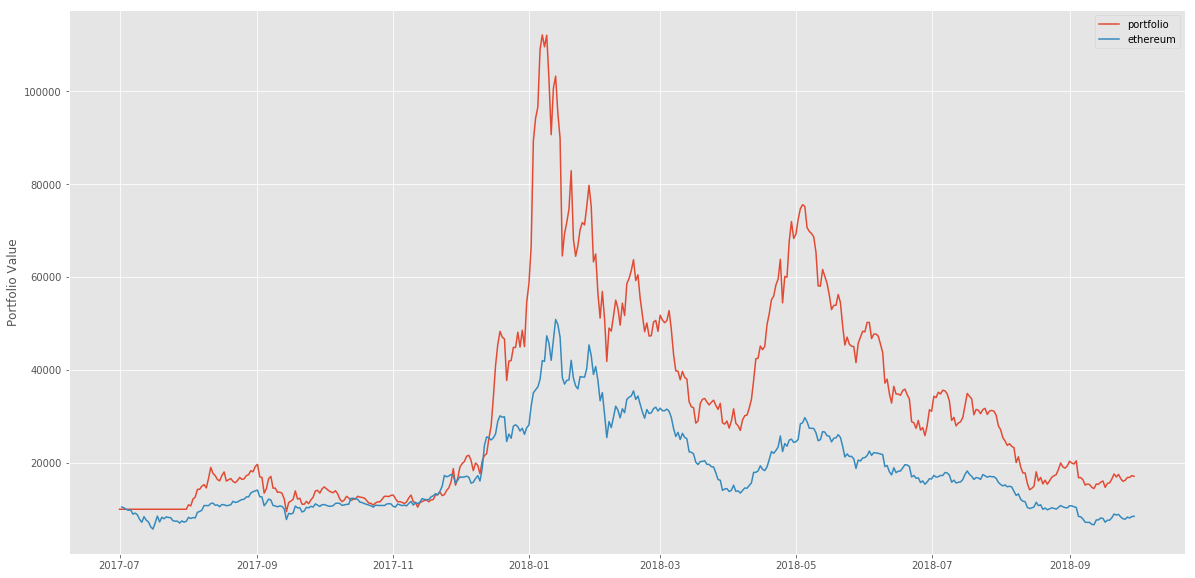



Holding the benchmark would turn 10000 USD into 8483.82 USD
Which is a change of -15.16 percent


In [117]:
resulting_portfolio = portfolio_value * money_invested
print("\n\nUsing the strategy would turn {} USD into {} USD".format(money_invested, round(resulting_portfolio[-1],2)))
print("Which is a change of {} percent".format(round((resulting_portfolio[-1] - money_invested) / money_invested * 100,2)))

plt.figure(figsize=(20,10))
plt.plot(resulting_portfolio, label="portfolio")
resulting_benchmark_portfolio = (data.loc[selected_benchmark]["pct_change"] + 1).cumprod() * money_invested
plt.plot(resulting_benchmark_portfolio, label=selected_benchmark)
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


print("\n\nHolding the benchmark would turn {} USD into {} USD".format(money_invested, round(resulting_benchmark_portfolio[-1],2)))
print("Which is a change of {} percent".format(round((resulting_benchmark_portfolio[-1] - money_invested) / money_invested * 100,2)))


Let's look at some more stats. Here we calculate the Sharpe ratio and the maximum drawdown of our portfolio:

In [118]:
def sharpe_ratio(simple_returns):
    return simple_returns.mean() * np.sqrt(365) / simple_returns.std()  # annualized Sharpe ratio

def max_drawdown(values):
    running_value = values.dropna()
    end = (np.maximum.accumulate(running_value) - running_value).idxmax()  # end of the period
    start = (running_value[:end]).idxmax()  # start of period
    max_draw = ((running_value[end]-running_value[start])/running_value[start]) * 100  # Maximum Drawdown
    return max_draw

simple_returns_portfoio = data["weighted_pct_change"].fillna(0).groupby(level=1).sum()
print("The Sharpe ratio is: {}".format(round(sharpe_ratio(simple_returns_portfoio),2)))
print("the maximum drawdown for the porfolio is {} percent".format(round(max_drawdown(resulting_portfolio),2)))
simple_returns_bench = data["pct_change"].loc[selected_benchmark].fillna(0)
print("\nThe Sharpe ratio benchmark is: {}".format(round(sharpe_ratio(simple_returns_bench),2)))
print("the maximum drawdown for the benchmark is {} percent".format(round(max_drawdown(resulting_benchmark_portfolio),2)))

The Sharpe ratio is: 1.0
the maximum drawdown for the porfolio is -87.33 percent

The Sharpe ratio benchmark is: 0.46
the maximum drawdown for the benchmark is -86.86 percent


Let's  look at our monthly returns and the monthly  Sharpe ratio:

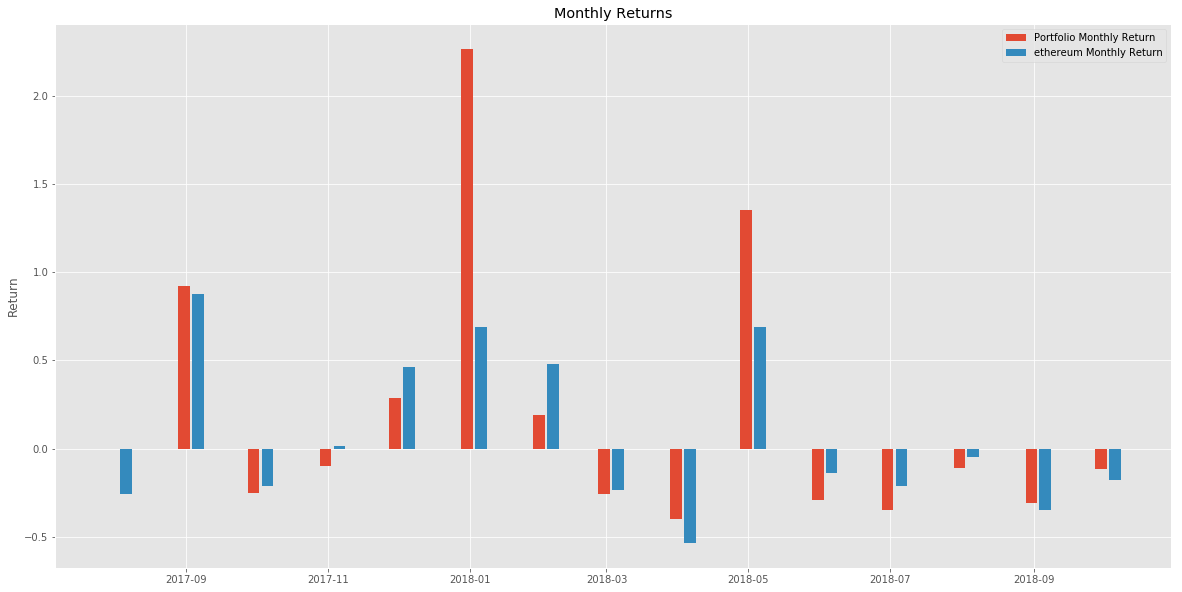

In [119]:
monthly_portfolio = simple_returns_portfoio.resample("M").apply(lambda x: (x + 1).prod()) -1
monthly_bench = simple_returns_bench.resample("M").apply(lambda x: (x + 1).prod()) -1 

plt.figure(figsize=(20,10))
plt.bar(monthly_portfolio.index, monthly_portfolio, 5, label="Portfolio Monthly Return")
plt.bar(date2num(monthly_bench.index) + 6, monthly_bench, 5, label="{} Monthly Return".format(selected_benchmark))
plt.legend()
plt.title("Monthly Returns")
plt.ylabel("Return")
plt.show()

Now we calculate the beta of the portfolio compared to the benchmark:

In [121]:
Y = (portfolio_value).pct_change().dropna().replace(np.inf, 0)
X = data.loc[selected_benchmark]["pct_change"].dropna().replace(np.inf, 0)
model = sm.OLS(Y, X)
results = model.fit()

print("The beta of the portfolio according to the benchmark is {}".format(results.params.pct_change.__self__[0]))

The beta of the portfolio according to the benchmark is 0.8268853877522795


Calculate a roling beta for each month:

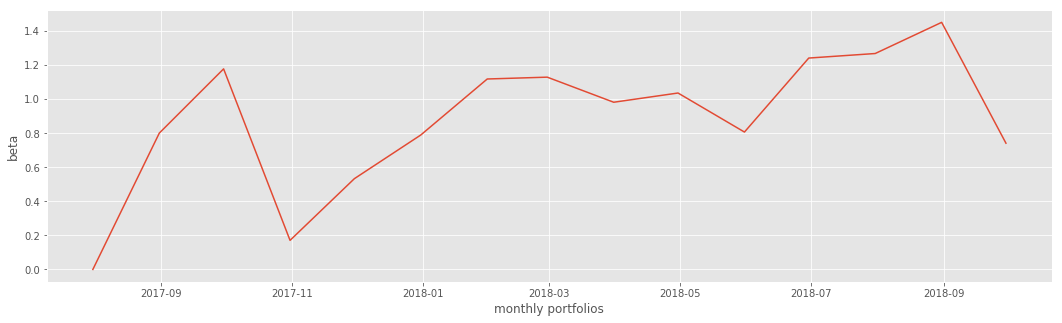

In [122]:
months = simple_returns_portfoio.index.to_series().apply(lambda x: dt.datetime.strftime(x, '%b %Y')).drop_duplicates()
monthly_beta = []

for month in months:
    y = Y[month]
    x = X[month]
    model = sm.OLS(y, x)  # Do a simple linear regression
    results = model.fit()
    monthly_beta.append(results.params.pct_change.__self__)

fig=plt.figure(figsize=(18, 5))    
plt.plot(monthly_portfolio.index,monthly_beta)
plt.ylabel('beta')
plt.xlabel('monthly portfolios')
plt.show()


Finally, let's see how often the projects got selected: 

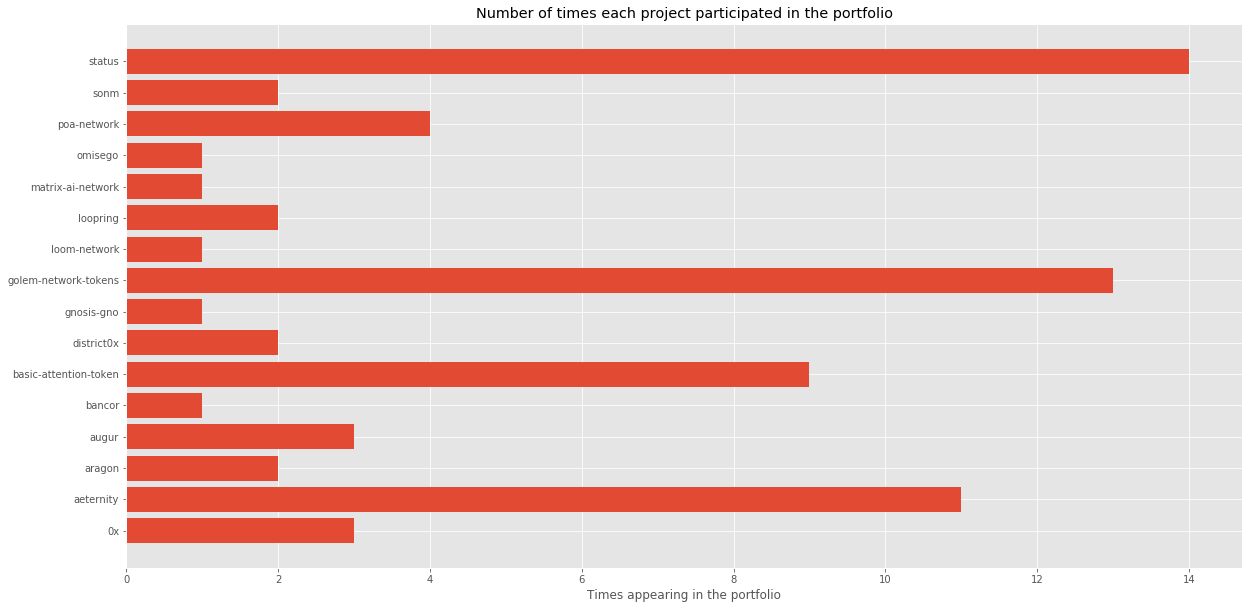

In [59]:
plt.figure(figsize=(20,10))
plt.barh(weights[weights > 0].groupby(level=0).count().index, weights[weights > 0].groupby(level=0).count())
plt.title("Number of times each project participated in the portfolio")
plt.xlabel("Times appearing in the portfolio")
plt.show()